Objective: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

Learning Goals:

Understand hyperparameter tuning through grid search
Compare manual implementation with built-in functions
Learn to create and evaluate voting classifiers
Work with multiple real-world datasets
Visualize model performance using ROC curves and confusion matrices
Datasets Used:

Wine Quality - Predicting wine quality based on chemical properties
HR Attrition - Predicting employee turnover
Banknote Authentication - Detecting counterfeit banknotes
QSAR Biodegradation - Predicting chemical biodegradability


## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [9]:
# Part 1: Import Libraries and Setup

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)

# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Models and Parameter Grids

In [10]:
# Define base models and parameter grids

# Decision Tree
param_grid_dt = {
    'feature_selection__k': [2, 3, 4],   # Banknote has 4 features max
    'classifier__max_depth': [2, 4, 6, None],
    'classifier__min_samples_split': [2, 5, 10]
}

# k-Nearest Neighbors
param_grid_knn = {
    'feature_selection__k': [2, 3, 4],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}

# Logistic Regression
param_grid_lr = {
    'feature_selection__k': [2, 3, 4],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs'],
    'classifier__max_iter': [500]
}

# List of classifiers to tune
classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree"),
    (KNeighborsClassifier(), param_grid_knn, "kNN"),
    (LogisticRegression(random_state=42), param_grid_lr, "Logistic Regression")
]


## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### Banknote Authentication Dataset



In [11]:
def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"

## Part 4: Manual Grid Search Implementation



In [12]:
# Part 4: Manual Grid Search Implementation

def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- Manual Grid Search for {name} ---")
        best_score, best_params = -1, None

        # 1. Adjust feature_selection__k
        adjusted_grid = {}
        for key, values in param_grid.items():
            if key == "feature_selection__k":
                adjusted_grid[key] = [n_features if v == "all" else v
                                      for v in values if v == "all" or v <= n_features]
            else:
                adjusted_grid[key] = values

        # 2. Generate all hyperparameter combinations
        keys = list(adjusted_grid.keys())
        for combo in itertools.product(*[adjusted_grid[k] for k in keys]):
            params = dict(zip(keys, combo))
            fold_scores = []

            # 3. 5-fold CV
            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                # Build pipeline
                pipe = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance.__class__())
                ])
                pipe.set_params(**params)
                pipe.fit(X_tr, y_tr)

                # Predict probabilities & compute AUC
                y_val_proba = pipe.predict_proba(X_val)[:, 1]
                auc = roc_auc_score(y_val, y_val_proba)
                fold_scores.append(auc)

            # Mean AUC across folds
            mean_auc = np.mean(fold_scores)

            # Track best
            if mean_auc > best_score:
                best_score, best_params = mean_auc, params

        print(f"Best AUC={best_score:.4f}, Params={best_params}")

        # Final pipeline with best params
        final_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance.__class__())
        ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)
        best_estimators[name] = final_pipeline

    return best_estimators


**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [13]:
# Part 5: Built-in Grid SearchCV Implementation

def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}
    n_features = X_train.shape[1]
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # 1. Adjust feature_selection__k
        adjusted_grid = {}
        for key, values in param_grid.items():
            if key == "feature_selection__k":
                adjusted_grid[key] = [n_features if v == "all" else v
                                      for v in values if v == "all" or v <= n_features]
            else:
                adjusted_grid[key] = values

        # 2. Build pipeline
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # 3. Setup GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_grid,
            scoring='roc_auc',
            cv=cv_splitter,
            n_jobs=-1,
            refit=True,
            verbose=0
        )

        # 4. Fit grid search
        grid_search.fit(X_train, y_train)

        # 5. Save results
        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

        print(f"Best AUC={grid_search.best_score_:.4f}, Params={grid_search.best_params_}")

    return results_builtin


## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [14]:
# Part 6: Model Evaluation and Voting Classifiers

def evaluate_models(X_train, y_train, X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # --- Individual model evaluation ---
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # --- Voting Classifier ---
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual soft voting: average probabilities
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # --- Compute voting metrics ---
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # --- Visualizations ---
    plt.figure(figsize=(12, 5))

    # ROC Curves
    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add Voting Classifier ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues", colorbar=False)
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg


## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [15]:
# Part 7: Complete Pipeline Function

def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for Wine Quality dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # --- Part 1: Manual Grid Search ---
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(
        X_train, y_train, X_test, y_test, manual_estimators, actual_name, "Manual"
    )

    # --- Part 2: Built-in Grid SearchCV ---
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                          for name, results in builtin_results.items()}

    builtin_votes, builtin_proba = evaluate_models(
        X_train, y_train, X_test, y_test, builtin_estimators, actual_name, "Built-in"
    )

    print(f"\nCompleted processing for {actual_name}")
    print("=" * 80)


## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!




################################################################################
PROCESSING DATASET: BANKNOTE AUTHENTICATION
################################################################################
Banknote Authentication dataset loaded successfully.
Training set shape: (960, 4)
Testing set shape: (412, 4)
------------------------------

RUNNING MANUAL GRID SEARCH FOR BANKNOTE AUTHENTICATION

--- Manual Grid Search for Decision Tree ---
Best AUC=0.9873, Params={'feature_selection__k': 3, 'classifier__max_depth': 6, 'classifier__min_samples_split': 5}

--- Manual Grid Search for kNN ---
Best AUC=1.0000, Params={'feature_selection__k': 3, 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}

--- Manual Grid Search for Logistic Regression ---
Best AUC=0.9995, Params={'feature_selection__k': 3, 'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'classifier__max_iter': 500}

EVALUATING MANUAL MODELS FOR BANKNOTE AUTHENTICATION

--- Individu

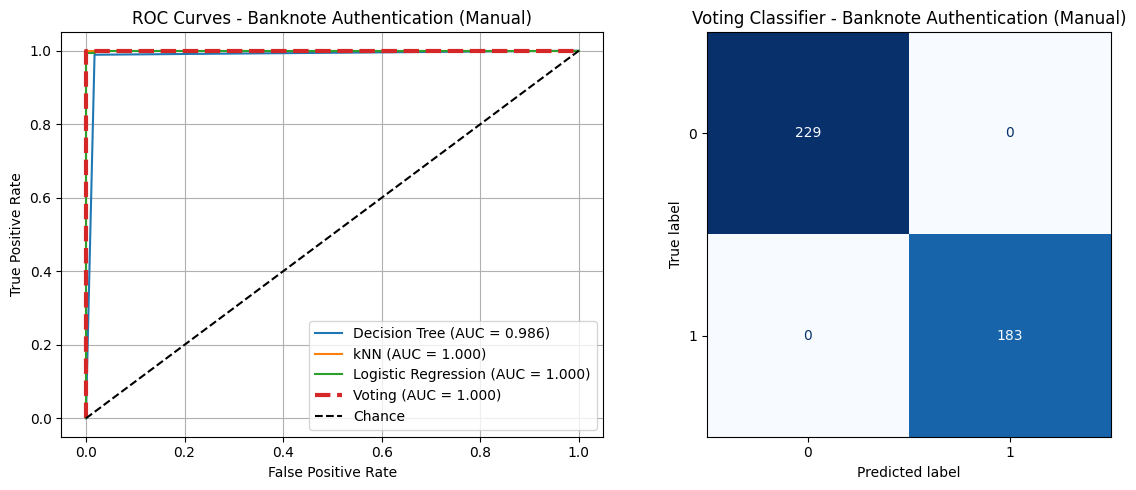


RUNNING BUILT-IN GRID SEARCH FOR BANKNOTE AUTHENTICATION

--- GridSearchCV for Decision Tree ---
Best AUC=0.9869, Params={'classifier__max_depth': 6, 'classifier__min_samples_split': 10, 'feature_selection__k': 3}

--- GridSearchCV for kNN ---
Best AUC=1.0000, Params={'classifier__n_neighbors': 5, 'classifier__weights': 'distance', 'feature_selection__k': 3}

--- GridSearchCV for Logistic Regression ---
Best AUC=0.9995, Params={'classifier__C': 10, 'classifier__max_iter': 500, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 3}

EVALUATING BUILT-IN MODELS FOR BANKNOTE AUTHENTICATION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.9854
  Precision: 0.9784
  Recall: 0.9891
  F1-Score: 0.9837
  ROC AUC: 0.9856

kNN:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC AUC: 1.0000

Logistic Regression:
  Accuracy: 0.9903
  Precision: 0.9786
  Recall: 1.0000
  F1-Score: 0.9892
  ROC AUC: 0.9999

--- Built-in

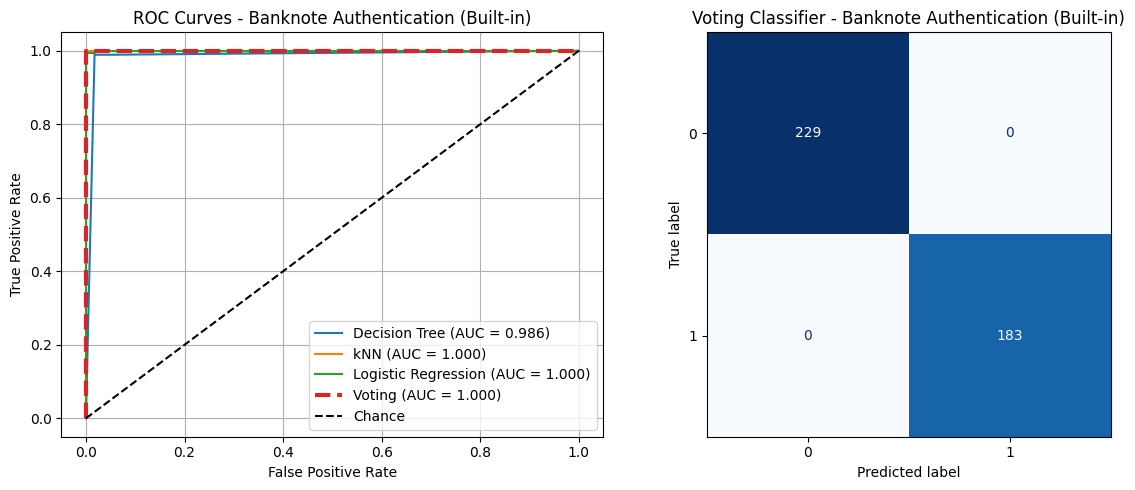


Completed processing for Banknote Authentication

ALL DATASETS PROCESSED!


In [16]:

datasets = [
    (load_banknote, "Banknote Authentication")
]

# Run pipeline
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)
